In [130]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/tjk_dataset/kaggle/train.csv')
print(train.head())

   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0


In [117]:
import pandas as pd

test = pd.read_csv('/content/drive/MyDrive/tjk_dataset/kaggle/test.csv')
print(test.head())

       id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    male   45   177.0    81.0       7.0        87.0       39.8
1  750001    male   26   200.0    97.0      20.0       101.0       40.5
2  750002  female   29   188.0    85.0      16.0       102.0       40.4
3  750003  female   39   172.0    73.0      20.0       107.0       40.6
4  750004  female   30   173.0    67.0      16.0        94.0       40.5


In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [122]:
train_df = train
test_df = test

In [123]:
train_id = train_df['id']
test_id = test_df['id']
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

print("Veri setleri yüklendi ve ID'ler ayrıldı.")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Veri setleri yüklendi ve ID'ler ayrıldı.
Train shape: (750000, 8), Test shape: (250000, 7)


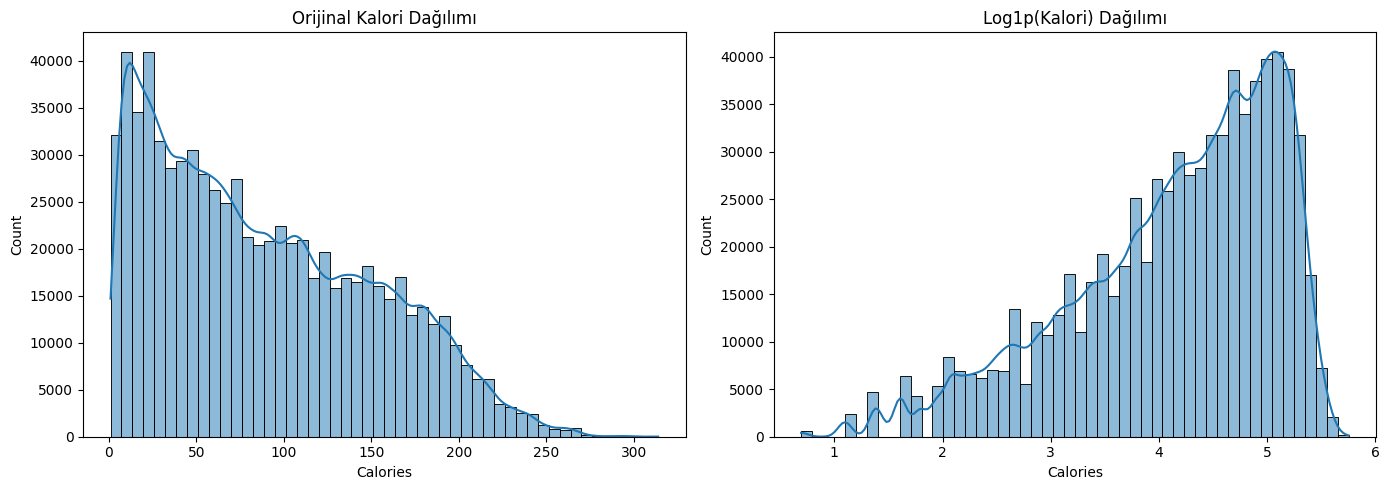

Birleştirilmiş özelliklerin şekli: (1000000, 7)


In [126]:
# --- 1. Hedef Değişken Analizi ve Dönüşümü ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Calories'], kde=True, bins=50)
plt.title('Orijinal Kalori Dağılımı')

# Log dönüşümü (RMSLE için)
train_df['Calories'] = np.log1p(train_df['Calories'])

plt.subplot(1, 2, 2)
sns.histplot(train_df['Calories'], kde=True, bins=50)
plt.title('Log1p(Kalori) Dağılımı')
plt.tight_layout()
plt.show()

# Hedef değişkeni ayıralım
y_target = train_df['Calories']
train_features = train_df.drop('Calories', axis=1)

# Test setinde 'Calories' sütunu olmadığı için birleştirmeden önce ayıralım
# Özellik mühendisliği için train ve test setlerini birleştirelim
# Bu, encoding gibi işlemlerin tutarlı olmasını sağlar
combined_features = pd.concat([train_features, test_df], keys=['train', 'test'], sort=False)

print(f"Birleştirilmiş özelliklerin şekli: {combined_features.shape}")


In [127]:
print(f"\n'Sex' sütunu değerleri: {combined_features['Sex'].unique()}")
combined_features = pd.get_dummies(combined_features, columns=['Sex'], prefix='Sex', drop_first=True)
print("'Sex' sütunu one-hot encode edildi.")


'Sex' sütunu değerleri: ['male' 'female']
'Sex' sütunu one-hot encode edildi.


In [128]:
print("\nÖzellik mühendisliği başlıyor...")

# Varsayım: Height cm, Weight kg. Bu varsayımları kontrol etmelisiniz!
# Gerçek veri setindeki Height ve Weight değerlerinin aralığına bakarak teyit edin.
# Örneğin: print(combined_features['Height'].describe())
#          print(combined_features['Weight'].describe())
# Eğer Height 1.5-2.5 arasındaysa metredir, (combined_features['Height'])**2 kullanılmalı.
# Eğer Height 150-200 arasındaysa cm'dir, (combined_features['Height']/100)**2 kullanılmalı.
# Dummy veride cm olarak varsaydık.
combined_features['BMI_like'] = combined_features['Weight'] / ((combined_features['Height'] / 100)**2 + 1e-6) # 1e-6 sıfıra bölmeyi engeller

combined_features['Duration_x_HeartRate'] = combined_features['Duration'] * combined_features['Heart_Rate']
combined_features['Duration_x_BodyTemp'] = combined_features['Duration'] * combined_features['Body_Temp']
combined_features['Age_x_HeartRate'] = combined_features['Age'] * combined_features['Heart_Rate']
combined_features['Weight_x_Duration'] = combined_features['Weight'] * combined_features['Duration']

# Daha fazla özellik eklenebilir:
combined_features['Age_sq'] = combined_features['Age']**2
combined_features['Duration_sq'] = combined_features['Duration']**2
combined_features['Heart_Rate_sq'] = combined_features['Heart_Rate']**2
combined_features['Body_Temp_sq'] = combined_features['Body_Temp']**2
combined_features['Weight_sq'] = combined_features['Weight']**2
combined_features['Height_sq'] = combined_features['Height']**2


# Aktivite Yoğunluğu Proxy'si (Yaş'ın 0 veya çok küçük olmamasına dikkat)
combined_features['Activity_Intensity_Proxy'] = combined_features['Heart_Rate'] / (220 - combined_features['Age'] + 1e-6)

# Yaş ve Cinsiyet Etkileşimi (Eğer Sex_male sütunu varsa)
if 'Sex_male' in combined_features.columns:
    combined_features['Age_x_Sex_male'] = combined_features['Age'] * combined_features['Sex_male']
    combined_features['Duration_x_Sex_male'] = combined_features['Duration'] * combined_features['Sex_male']


# Oluşturulan özelliklerde NaN veya Inf kontrolü
print(f"\nNaN değerler var mı? {combined_features.isnull().sum().any()}")
print(f"Inf değerler var mı? {np.isinf(combined_features.select_dtypes(include=np.number)).sum().any()}")

# Inf değerleri NaN ile değiştirebilir ve sonra doldurabiliriz (eğer varsa)
combined_features.replace([np.inf, -np.inf], np.nan, inplace=True)
# NaN değerleri median ile doldurma (basit bir strateji, daha iyileri düşünülebilir)
for col in combined_features.columns:
    if combined_features[col].isnull().any():
        median_val = combined_features[col].median()
        combined_features[col].fillna(median_val, inplace=True)
        print(f"'{col}' sütunundaki NaN'ler median ({median_val}) ile dolduruldu.")


print("\nÖzellik mühendisliği tamamlandı.")
print(f"Yeni özelliklerle birleştirilmiş setin şekli: {combined_features.shape}")
print("İlk 5 satır:")
print(combined_features.head())

# Train ve test setlerini ayıralım
X_train = combined_features.loc['train']
X_test = combined_features.loc['test']

print(f"\nİşlenmiş X_train şekli: {X_train.shape}")
print(f"İşlenmiş X_test şekli: {X_test.shape}")
print(f"y_target (logaritması alınmış kalori) şekli: {y_target.shape}")



Özellik mühendisliği başlıyor...

NaN değerler var mı? False
Inf değerler var mı? False

Özellik mühendisliği tamamlandı.
Yeni özelliklerle birleştirilmiş setin şekli: (1000000, 21)
İlk 5 satır:
         Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Sex_male  \
train 0   36   189.0    82.0      26.0       101.0       41.0      True   
      1   64   163.0    60.0       8.0        85.0       39.7     False   
      2   51   161.0    64.0       7.0        84.0       39.8     False   
      3   20   192.0    90.0      25.0       105.0       40.7      True   
      4   38   166.0    61.0      25.0       102.0       40.6     False   

          BMI_like  Duration_x_HeartRate  Duration_x_BodyTemp  ...  \
train 0  22.955678                2626.0               1066.0  ...   
      1  22.582701                 680.0                317.6  ...   
      2  24.690396                 588.0                278.6  ...   
      3  24.414056                2625.0               1017.5  ...   
   

In [131]:
# --- 4. Özellik Ölçeklendirme ---
# StandardScaler kullanalım
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ölçeklenmiş veriyi DataFrame'e geri dönüştürelim (opsiyonel, model bazıları için array kabul eder)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nÖzellikler ölçeklendirildi.")
print("Ölçeklendirilmiş X_train ilk 5 satır:")
print(X_train_scaled_df.head())


Özellikler ölçeklendirildi.
Ölçeklendirilmiş X_train ilk 5 satır:
        Age    Height    Weight  Duration  Heart_Rate  Body_Temp  Sex_male  \
0 -0.357192  1.115235  0.490201  1.266324    0.583714   1.235772  1.001925   
1  1.487943 -0.912137 -1.083172 -0.888309   -1.109436  -0.431163 -0.998079   
2  0.631273 -1.068088 -0.797104 -1.008011   -1.215258  -0.302938 -0.998079   
3 -1.411555  1.349162  1.062337  1.146622    1.007002   0.851095  1.001925   
4 -0.225397 -0.678209 -1.011655  1.146622    0.689536   0.722869 -0.998079   

   BMI_like  Duration_x_HeartRate  Duration_x_BodyTemp  ...  \
0 -0.939008              1.162994             1.288292  ...   
1 -1.185799             -0.923974            -0.889529  ...   
2  0.208817             -1.022639            -1.003018  ...   
3  0.025969              1.161922             1.147159  ...   
4 -1.480887              1.081489             1.139884  ...   

   Weight_x_Duration    Age_sq  Duration_sq  Heart_Rate_sq  Body_Temp_sq  \
0        

In [132]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [135]:
# Önceki adımdan gelen değişkenleri kullandığımızı varsayıyorum:
# X_train_scaled_df: Ölçeklendirilmiş eğitim özellikleri
# y_target: Logaritması alınmış hedef değişken (Calories)
# X_test_scaled_df: Ölçeklendirilmiş test özellikleri
# test_id: Test seti için ID'ler

# Dummy veriler (Eğer önceki adımdan değişkenler gelmiyorsa, bu kısmı kaldırın)
# Bu dummy veriler sadece kodun çalışmasını sağlamak içindir.
# Gerçek verilerinizle bu kısma İHTİYAÇ YOKTUR.
if 'X_train_scaled_df' not in locals() or 'y_target' not in locals() or 'X_test_scaled_df' not in locals() or 'test_id' not in locals():
    print("Uyarı: Önceki adımdan gelen değişkenler bulunamadı. Dummy veriler oluşturuluyor.")
    num_train_samples = 750000
    num_test_samples = 500000
    num_features = X_train.shape[1] if 'X_train' in locals() else 15 # Önceki X_train'in sütun sayısını al veya varsayılan

    X_train_scaled_df = pd.DataFrame(np.random.rand(num_train_samples, num_features), columns=[f'feature_{i}' for i in range(num_features)])
    y_target = pd.Series(np.random.rand(num_train_samples) * 5 + 1) # log(calories) gibi bir aralıkta
    X_test_scaled_df = pd.DataFrame(np.random.rand(num_test_samples, num_features), columns=[f'feature_{i}' for i in range(num_features)])
    test_id = pd.Series(range(num_test_samples))
    # --- Dummy veri sonu ---

print("Model eğitimi ve tahmin aşamasına geçiliyor...")
print(f"X_train_scaled_df shape: {X_train_scaled_df.shape}")
print(f"y_target shape: {y_target.shape}")
print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}")




Model eğitimi ve tahmin aşamasına geçiliyor...
X_train_scaled_df shape: (750000, 21)
y_target shape: (750000,)
X_test_scaled_df shape: (250000, 21)


In [136]:
# 2. Eğitim ve Doğrulama Seti Oluşturma
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled_df, y_target, test_size=0.2, random_state=42
)

print(f"\nEğitim seti boyutu: {X_train_split.shape}")
print(f"Doğrulama seti boyutu: {X_val_split.shape}")



Eğitim seti boyutu: (600000, 21)
Doğrulama seti boyutu: (150000, 21)


In [137]:
# 3. Model Tanımlama ve Eğitimi (LightGBM)
# Temel LightGBM parametreleri. Bunlar daha sonra optimize edilebilir.
lgbm_params = {
    'objective': 'regression_l1', # L1 regression (MAE), RMSLE için 'regression_l2' (RMSE) de denenebilir.
                                  # log dönüşümü yaptığımız için RMSE (yani regression_l2) RMSLE'ye denk gelir.
                                  # 'regression' da RMSE için varsayılandır.
    'metric': 'rmse',             # Değerlendirme metriği RMSE (logaritmik hedefte)
    'n_estimators': 1000,         # Ağaç sayısı (erken durdurma ile optimize edilebilir)
    'learning_rate': 0.05,
    'feature_fraction': 0.8,      # Her ağaç için kullanılacak özellik oranı
    'bagging_fraction': 0.8,      # Her ağaç için kullanılacak veri örneği oranı
    'bagging_freq': 1,
    'lambda_l1': 0.1,             # L1 regularization
    'lambda_l2': 0.1,             # L2 regularization
    'num_leaves': 31,             # Bir ağaçtaki yaprak sayısı
    'verbose': -1,                # Çıktı detay seviyesi (-1 sessiz)
    'n_jobs': -1,                 # Kullanılacak işlemci çekirdeği sayısı (-1 tümü)
    'seed': 42,
    'boosting_type': 'gbdt',
}

model = lgb.LGBMRegressor(**lgbm_params)

print("\nLightGBM modeli eğitiliyor (erken durdurma ile)...")
# Erken durdurma için `eval_set` ve `callbacks` kullanalım
# callbacks parametresi LightGBM'in daha yeni sürümlerinde lgb.early_stopping gibi kullanılır.
# sklearn wrapper için fit metodunda eval_set, eval_metric ve early_stopping_rounds kullanılır.
model.fit(X_train_split, y_train_split,
          eval_set=[(X_val_split, y_val_split)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=10)])




LightGBM modeli eğitiliyor (erken durdurma ile)...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0605499


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=1000, n_jobs=-1, objective='regression_l1', seed=42,
              verbose=-1)

In [138]:
# 4. Yerel Değerlendirme
print("\nDoğrulama seti üzerinde tahmin yapılıyor...")
y_val_pred_log = model.predict(X_val_split)

# RMSLE hesaplama (logaritmik değerler üzerinde RMSE)
val_rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred_log))
print(f"Doğrulama Seti RMSLE (logaritmik ölçekte RMSE): {val_rmse:.5f}")

if val_rmse < 0.1:
    print("Harika! Yerel RMSLE skoru 0.1'in altında.")
else:
    print("Yerel RMSLE skoru 0.1'in üzerinde. Hiperparametre optimizasyonu veya özellik mühendisliği gerekebilir.")



Doğrulama seti üzerinde tahmin yapılıyor...
Doğrulama Seti RMSLE (logaritmik ölçekte RMSE): 0.06055
Harika! Yerel RMSLE skoru 0.1'in altında.


In [139]:
# 5. Test Seti Üzerinde Tahmin (Tüm eğitim verisiyle yeniden eğitilmiş model)
print("\nModel tüm eğitim verisiyle yeniden eğitiliyor...")
# Erken durdurma için en iyi iterasyon sayısını kullanabiliriz
# best_iteration_ = model.best_iteration_ # Eğer sklearn API'sinde varsa
# Ya da sabit sayıda eğitip, en iyi parametrelerle tüm veri üzerinde eğitiriz.
# Şimdilik, aynı parametrelerle tüm X_train_scaled_df üzerinde eğitelim.
# Daha iyi bir yaklaşım, çapraz doğrulama ile en iyi iterasyon sayısını bulmak ve onu kullanmaktır.
# Veya bulunan best_iteration ile yeniden eğitmek:
if hasattr(model, 'best_iteration_') and model.best_iteration_ is not None:
    print(f"En iyi iterasyon sayısı: {model.best_iteration_}")
    lgbm_params['n_estimators'] = model.best_iteration_ # En iyi iterasyon sayısını ayarla
else: # best_iteration_ yoksa (bazı sklearn wrapper versiyonlarında olmayabilir veya erken durdurma devreye girmemişse)
    print("Uyarı: model.best_iteration_ bulunamadı, n_estimators başlangıç değeriyle devam ediliyor.")
    # n_estimators'ı sabit bırakıyoruz (veya çapraz doğrulamadan gelen bir değeri kullanırız)

final_model = lgb.LGBMRegressor(**lgbm_params)
final_model.fit(X_train_scaled_df, y_target) # Tüm eğitim verisi

print("\nTest seti üzerinde tahmin yapılıyor...")
test_pred_log = final_model.predict(X_test_scaled_df)



Model tüm eğitim verisiyle yeniden eğitiliyor...
En iyi iterasyon sayısı: 1000

Test seti üzerinde tahmin yapılıyor...


In [140]:
# 6. Tahminleri Geri Dönüştürme
print("Tahminler orijinal ölçeğe geri dönüştürülüyor (np.expm1)...")
test_pred_original_scale = np.expm1(test_pred_log)

# Negatif tahminleri engelleme (genellikle expm1 sonrası olmaz ama tedbir amaçlı)
test_pred_original_scale[test_pred_original_scale < 0] = 0

print("Geri dönüştürülmüş tahminlerin ilk 5 değeri:")
print(test_pred_original_scale[:5])


Tahminler orijinal ölçeğe geri dönüştürülüyor (np.expm1)...
Geri dönüştürülmüş tahminlerin ilk 5 değeri:
[ 27.11827545 108.91201992  85.64184252 124.05165745  75.31089948]



Gönderim dosyası 'submission_lgbm_v1.csv' olarak kaydedildi.
       id    Calories
0  750000   27.118275
1  750001  108.912020
2  750002   85.641843
3  750003  124.051657
4  750004   75.310899


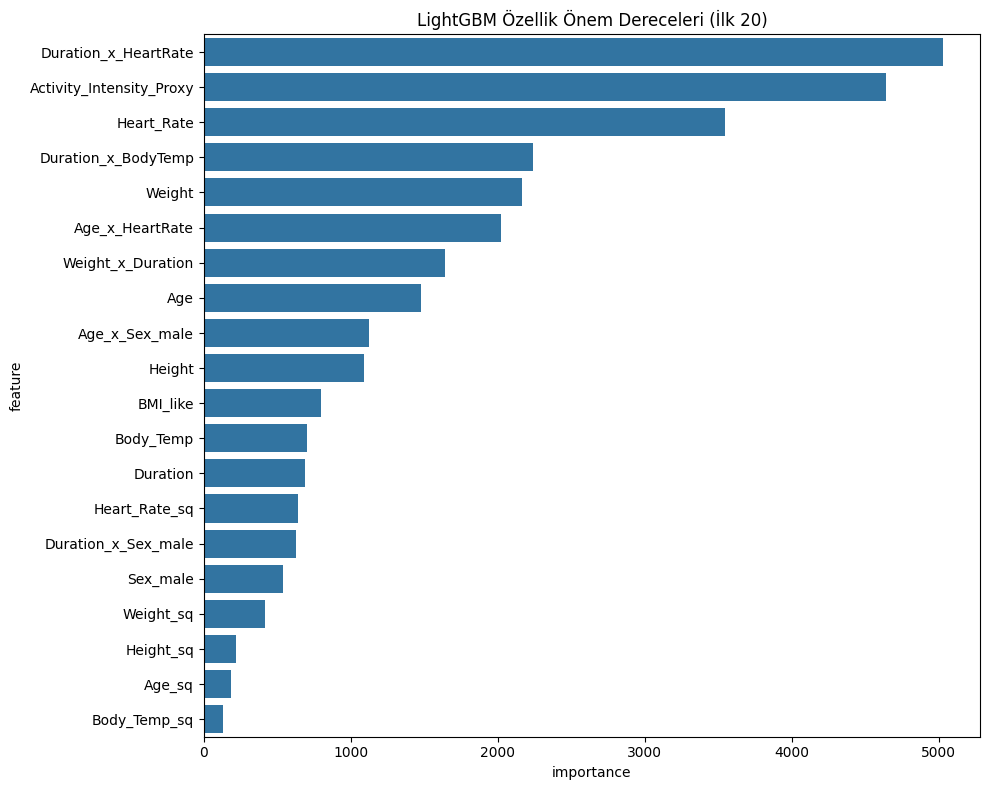


En önemli özellikler:
                     feature  importance
8       Duration_x_HeartRate        5028
18  Activity_Intensity_Proxy        4637
4                 Heart_Rate        3548
9        Duration_x_BodyTemp        2240
2                     Weight        2164
10           Age_x_HeartRate        2019
11         Weight_x_Duration        1639
0                        Age        1475
19            Age_x_Sex_male        1123
1                     Height        1090


In [141]:
# 7. Gönderim Dosyası Oluşturma
submission_df = pd.DataFrame({'id': test_id, 'Calories': test_pred_original_scale})

# ID sütununun integer olduğundan emin olalım (Kaggle genellikle integer ID bekler)
submission_df['id'] = submission_df['id'].astype(int)

submission_filename = "submission_lgbm_v1.csv"
submission_df.to_csv(submission_filename, index=False)
print(f"\nGönderim dosyası '{submission_filename}' olarak kaydedildi.")
print(submission_df.head())

# Özellik Önem Dereceleri (Opsiyonel, modelin neye odaklandığını görmek için)
if hasattr(final_model, 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'feature': X_train_scaled_df.columns,
        'importance': final_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # İlk 20 özelliği göster
    plt.title('LightGBM Özellik Önem Dereceleri (İlk 20)')
    plt.tight_layout()
    plt.show()
    print("\nEn önemli özellikler:")
    print(feature_importance_df.head(10))

In [133]:
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

In [134]:
train["BMI"] = train["Weight"] / ((train["Height"]/100) ** 2)
test["BMI"] = test["Weight"] / ((test["Height"]/100) ** 2)

In [84]:
train["HR_per_min"] = train["Heart_Rate"] / train["Duration"]
test["HR_per_min"] = test["Heart_Rate"] / test["Duration"]

In [85]:
train["Intensity"] = (train["Heart_Rate"] * train["Body_Temp"]) / train["Duration"]
test["Intensity"] = (test["Heart_Rate"] * test["Body_Temp"]) / test["Duration"]

In [86]:
test['Metabolic_Load'] = test['Weight'] * test['Duration'] * test['Heart_Rate']

In [87]:
train['Metabolic_Load'] = train['Weight'] * train['Duration'] * train['Heart_Rate']
train['Age_Weight_Ratio'] = train['Age'] / train['Weight']
test['Age_Weight_Ratio'] = test['Age'] / test['Weight']  # Test için de aynı işlem

In [22]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [24]:
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred)
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 15.65


In [25]:
from sklearn.metrics import mean_squared_log_error

# Negatif değer olasılığına karşı önlem
y_pred = np.maximum(y_pred, 0)
y_valid = np.maximum(y_valid, 0)

# MSLE hesapla
msle = mean_squared_log_error(y_valid, y_pred)
print(f"Validation MSLE: {msle:.5f}")

Validation MSLE: 0.00229


In [26]:
# Test setinde "id" dışında kalan sütunları al
X_test = test[features]

# Tahmin yap
test_preds = model.predict(X_test)

# Submission dosyası
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": test_preds
})

submission.to_csv("submission.csv", index=False)

In [30]:
from lightgbm import early_stopping, log_evaluation

# Modeli tanımla
lgb_model = LGBMRegressor(
    objective='regression',
    metric='msle',
    learning_rate=0.05,
    n_estimators=1000,
    random_state=42
)

# Modeli eğit
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='msle',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(100)  # her 100 iterasyonda bir log
    ]
)

# Tahmin
y_pred_lgb = lgb_model.predict(X_valid)
y_pred_lgb = np.maximum(y_pred_lgb, 0)

# MSLE hesapla
from sklearn.metrics import mean_squared_log_error
msle_lgb = mean_squared_log_error(y_valid, y_pred_lgb)
print(f"LightGBM MSLE: {msle_lgb:.5f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 502432, number of used features: 13
[LightGBM] [Info] Start training from score 102.729641


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation